In [ ]:
!pip install scikit-learn==1.0.2
!pip install catboost

In [ ]:
!pip install optuna-integration[sklearn]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from optuna.integration import OptunaSearchCV
from imblearn.over_sampling import SMOTE
import warnings
from collections import Counter
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('Train.csv')
df.head()

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
0,ID_266671248032267278,266671,Kenya,248032,267278,Type_1,8448.0,8448.0,2022-08-30,2022-09-06,7,Repeat Loan,120.85,0.014305,121.0,0
1,ID_248919228515267278,248919,Kenya,228515,267278,Type_1,25895.0,25979.0,2022-07-30,2022-08-06,7,Repeat Loan,7768.50,0.300000,7794.0,0
2,ID_308486370501251804,308486,Kenya,370501,251804,Type_7,6900.0,7142.0,2024-09-06,2024-09-13,7,Repeat Loan,1380.00,0.200000,1428.0,0
3,ID_266004285009267278,266004,Kenya,285009,267278,Type_1,8958.0,9233.0,2022-10-20,2022-10-27,7,Repeat Loan,2687.40,0.300000,2770.0,0
4,ID_253803305312267278,253803,Kenya,305312,267278,Type_1,4564.0,4728.0,2022-11-28,2022-12-05,7,Repeat Loan,1369.20,0.300000,1418.0,0


In [ ]:
# @title
# def detect_outliers(train,n,features):
#     outlier_indices = []

#     # iterate over features(columns)
#     for col in features:
#         # 1st quartile (25%)
#         Q1 = np.percentile(train[col], 25)
#         # 3rd quartile (75%)
#         Q3 = np.percentile(train[col],75)
#         # Interquartile range (IQR)
#         IQR = Q3 - Q1

#         # outlier step
#         outlier_step = 1.5 * IQR

#         # Determine a list of indices of outliers for feature col
#         outlier_list_col = train[(train[col] < Q1 - outlier_step) | (train[col] > Q3 + outlier_step )].index

#         # append the found outlier indices for col to the list of outlier indices
#         outlier_indices.extend(outlier_list_col)

#     # select observations containing more than 2 outliers
#     outlier_indices = Counter(outlier_indices)
#     multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )

#     return multiple_outliers

# # detect outliers from Age, SibSp , Parch and Fare
# # These are the numerical features present in the dataset
# Outliers_to_drop = detect_outliers(df,2,['Total_Amount', 'Total_Amount_to_Repay', 'duration',
#        'Amount_Funded_By_Lender', 'Lender_portion_Funded',
#        'Lender_portion_to_be_repaid'])



In [ ]:
# @title
# df.loc[Outliers_to_drop]

In [ ]:
# df = df.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)
# df.shape

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68654 entries, 0 to 68653
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           68654 non-null  object 
 1   customer_id                  68654 non-null  int64  
 2   country_id                   68654 non-null  object 
 3   tbl_loan_id                  68654 non-null  int64  
 4   lender_id                    68654 non-null  int64  
 5   loan_type                    68654 non-null  object 
 6   Total_Amount                 68654 non-null  float64
 7   Total_Amount_to_Repay        68654 non-null  float64
 8   disbursement_date            68654 non-null  object 
 9   due_date                     68654 non-null  object 
 10  duration                     68654 non-null  int64  
 11  New_versus_Repeat            68654 non-null  object 
 12  Amount_Funded_By_Lender      68654 non-null  float64
 13  Lender_portion_F

In [ ]:
cols_to_drop = ['customer_id',	'country_id',	'tbl_loan_id',	'lender_id']
df.drop(cols_to_drop, axis=1, inplace=True)
df.head()

,ID,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
0,ID_266671248032267278,Type_1,8448.0,8448.0,2022-08-30,2022-09-06,7,Repeat Loan,120.85,0.014305,121.0,0
1,ID_248919228515267278,Type_1,25895.0,25979.0,2022-07-30,2022-08-06,7,Repeat Loan,7768.50,0.300000,7794.0,0
2,ID_308486370501251804,Type_7,6900.0,7142.0,2024-09-06,2024-09-13,7,Repeat Loan,1380.00,0.200000,1428.0,0
3,ID_266004285009267278,Type_1,8958.0,9233.0,2022-10-20,2022-10-27,7,Repeat Loan,2687.40,0.300000,2770.0,0
4,ID_253803305312267278,Type_1,4564.0,4728.0,2022-11-28,2022-12-05,7,Repeat Loan,1369.20,0.300000,1418.0,0


In [ ]:
cat_des = df.select_dtypes(exclude=np.number)
cat_des.describe(include='object')

,ID,loan_type,disbursement_date,due_date,New_versus_Repeat
count,68654,68654,68654,68654,68654
unique,68654,22,768,893,2
top,ID_266671248032267278,Type_1,2022-07-16,2022-07-23,Repeat Loan
freq,1,61723,938,940,68087


In [ ]:
df.describe()

,Total_Amount,Total_Amount_to_Repay,duration,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
count,6.865400e+04,6.865400e+04,68654.000000,6.865400e+04,68654.000000,6.865400e+04,68654.000000
mean,1.483683e+04,1.563993e+04,8.544586,2.545663e+03,0.218679,2.652621e+03,0.018324
std,1.416499e+05,1.650784e+05,13.343145,1.192272e+04,0.129832,1.338006e+04,0.134120
min,2.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,2.295000e+03,2.329000e+03,7.000000,2.340000e+02,0.118712,2.390000e+02,0.000000
50%,5.249000e+03,5.325000e+03,7.000000,9.150000e+02,0.300000,9.340000e+02,0.000000
75%,1.145000e+04,1.165000e+04,7.000000,2.272650e+03,0.300000,2.317000e+03,0.000000
max,2.300000e+07,2.541500e+07,1096.000000,1.600000e+06,1.168119,1.821338e+06,1.000000


In [ ]:
df.target.value_counts()

,count
target,
0,67396
1,1258


In [ ]:
df.loan_type.sort_values().value_counts()

,count
loan_type,
Type_1,61723
Type_7,2790
Type_5,1521
Type_4,1235
Type_10,466
Type_6,357
Type_9,205
Type_14,99
Type_2,74


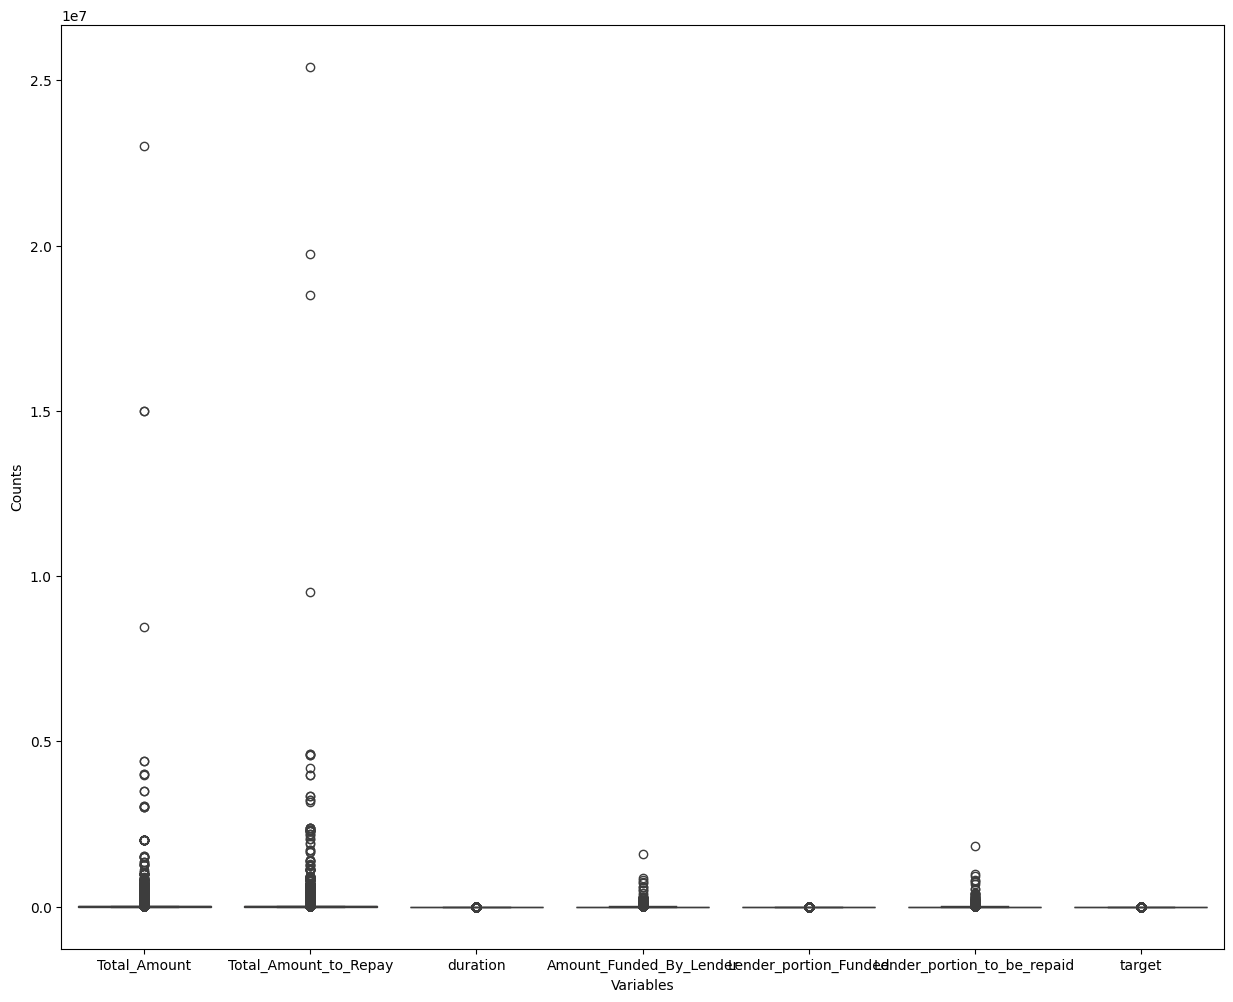

In [ ]:
plt.figure(figsize=(15, 12))
sns.boxplot(df)
plt.xlabel('Variables')

plt.ylabel('Counts')

# Display the plot to visualize it.
plt.show()


<Axes: >

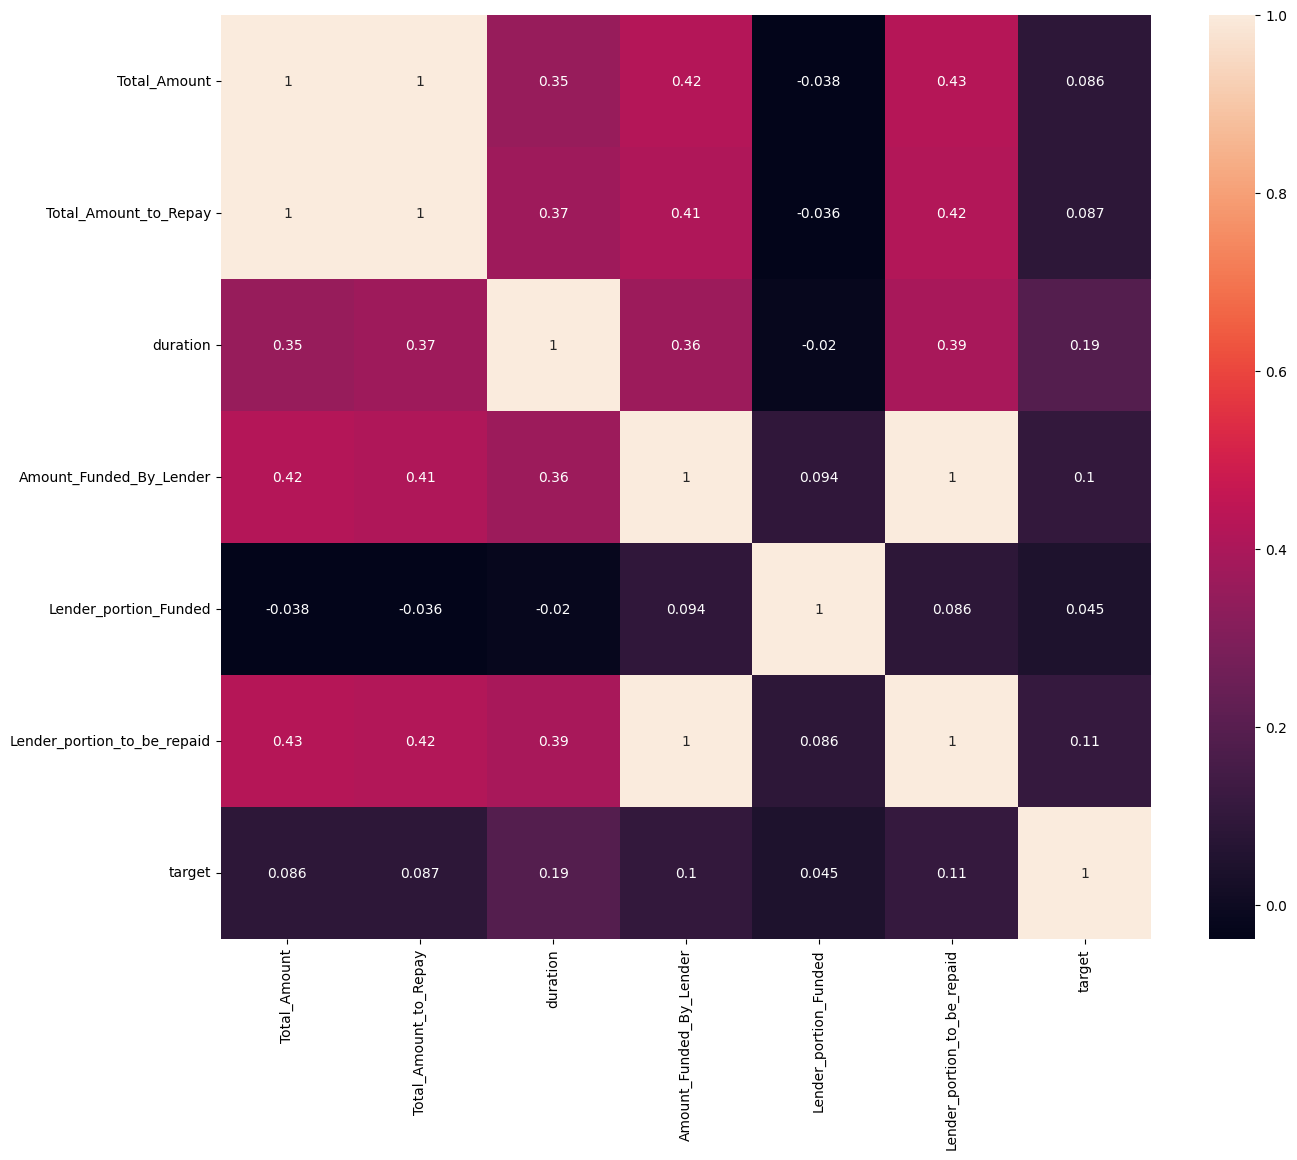

In [ ]:
plt.figure(figsize=(15, 12))
# plot relevant feature interactions
num = df.select_dtypes(include=['float64', 'int64'])
sns.heatmap(num.corr(), annot=True)

In [ ]:
# Function to calculate outliers using IQR method
def detect_outliers_iqr(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)  # First quartile (25%)
    Q3 = dataframe[column].quantile(0.75)  # Third quartile (75%)
    IQR = Q3 - Q1  # Interquartile Range

    # Define lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Detect outliers
    outliers = ((dataframe[column] < lower_bound) | (dataframe[column] > upper_bound))
    return outliers
df2 = df.copy()
# Identify numeric columns
numeric_columns = df2.select_dtypes(include=np.number).columns

# Create new variables to store outliers for each numeric column
for column in numeric_columns:
    df2[f'{column}_outliers'] = detect_outliers_iqr(df2, column)

# Optionally: Create a summary of outliers
outliers_summary = pd.DataFrame({
    'Column': numeric_columns,
    'Num_Outliers': [df2[f'{col}_outliers'].sum() for col in numeric_columns]
}).sort_values(by='Num_Outliers', ascending=False)


# Display the dataframe and outlier summary
print(outliers_summary)

                        Column  Num_Outliers
1        Total_Amount_to_Repay          6972
0                 Total_Amount          6825
5  Lender_portion_to_be_repaid          6778
3      Amount_Funded_By_Lender          6726
2                     duration          3681
6                       target          1258
4        Lender_portion_Funded           214


In [ ]:
df.shape

(68654, 12)

In [ ]:
num = df.select_dtypes(include=np.number)


In [ ]:
num.skew()

,0
Total_Amount,103.827538
Total_Amount_to_Repay,104.578767
duration,34.058866
Amount_Funded_By_Lender,61.063667
Lender_portion_Funded,-0.211887
Lender_portion_to_be_repaid,63.197764
target,7.182955


In [ ]:
num.kurtosis()

,0
Total_Amount,14022.343067
Total_Amount_to_Repay,13654.584956
duration,2087.994523
Amount_Funded_By_Lender,6105.025308
Lender_portion_Funded,2.217173
Lender_portion_to_be_repaid,6422.274554
target,49.596292


In [ ]:
num.corr()

,Total_Amount,Total_Amount_to_Repay,duration,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
Total_Amount,1.000000,0.996759,0.354523,0.420987,-0.038000,0.426856,0.086043
Total_Amount_to_Repay,0.996759,1.000000,0.371108,0.410123,-0.036009,0.418614,0.087089
duration,0.354523,0.371108,1.000000,0.364851,-0.019972,0.394855,0.189889
Amount_Funded_By_Lender,0.420987,0.410123,0.364851,1.000000,0.093573,0.997542,0.101845
Lender_portion_Funded,-0.038000,-0.036009,-0.019972,0.093573,1.000000,0.085730,0.045418
Lender_portion_to_be_repaid,0.426856,0.418614,0.394855,0.997542,0.085730,1.000000,0.109517
target,0.086043,0.087089,0.189889,0.101845,0.045418,0.109517,1.000000


In [ ]:
num2 = num.copy()
# columns_to_transform = num2.columns
# for col in columns_to_transform:
#     num2[col] = np.log1p(num2[col])

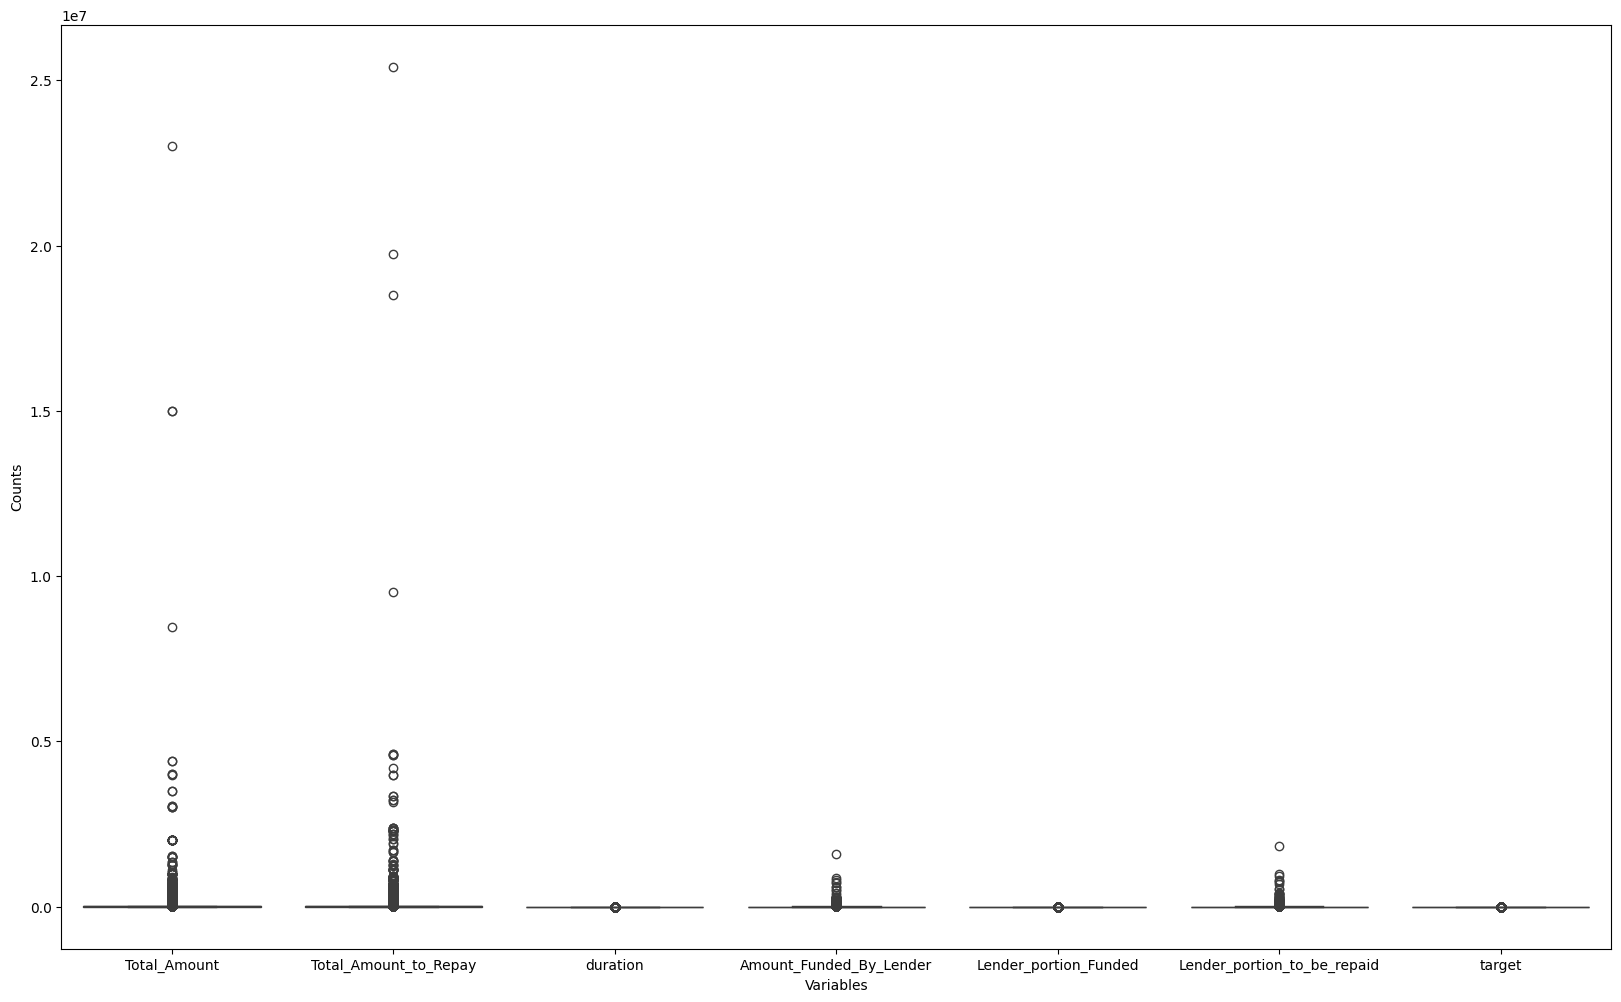

In [ ]:
plt.figure(figsize=(20, 12))
sns.boxplot(num2)
plt.xlabel('Variables')

plt.ylabel('Counts')

# Display the plot to visualize it.
plt.show()


In [ ]:
# @title
# for col in num2.columns:
#     if np.issubdtype(num2[col].dtype, np.number):  # Ensure column is numeric
#         # Calculate Q1 (25th percentile) and Q3 (75th percentile)
#         Q1 = num2[col].quantile(0.25)
#         Q3 = num2[col].quantile(0.75)

#         # Calculate the interquartile range (IQR)
#         IQR = Q3 - Q1

#         # Determine the lower and upper bounds for outliers
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR

#         # Identify outliers
#         lower_outliers = num2[col] < lower_bound
#         upper_outliers = num2[col] > upper_bound

#         # Calculate 1st and 99th percentiles for replacement
#         p1 = num2[col].quantile(0.01)
#         p99 = num2[col].quantile(0.99)

#         # Replace outliers
#         num2.loc[lower_outliers, col] = p1
#         num2.loc[upper_outliers, col] = p99

#         print(f"Processed column '{col}':")
#         print(f" - Lower outliers replaced with 1st percentile ({p1})")
#         print(f" - Upper outliers replaced with 99th percentile ({p99})\n")


In [ ]:
num2.head()

,Total_Amount,Total_Amount_to_Repay,duration,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
0,8448.0,8448.0,7,120.85,0.014305,121.0,0
1,25895.0,25979.0,7,7768.50,0.300000,7794.0,0
2,6900.0,7142.0,7,1380.00,0.200000,1428.0,0
3,8958.0,9233.0,7,2687.40,0.300000,2770.0,0
4,4564.0,4728.0,7,1369.20,0.300000,1418.0,0


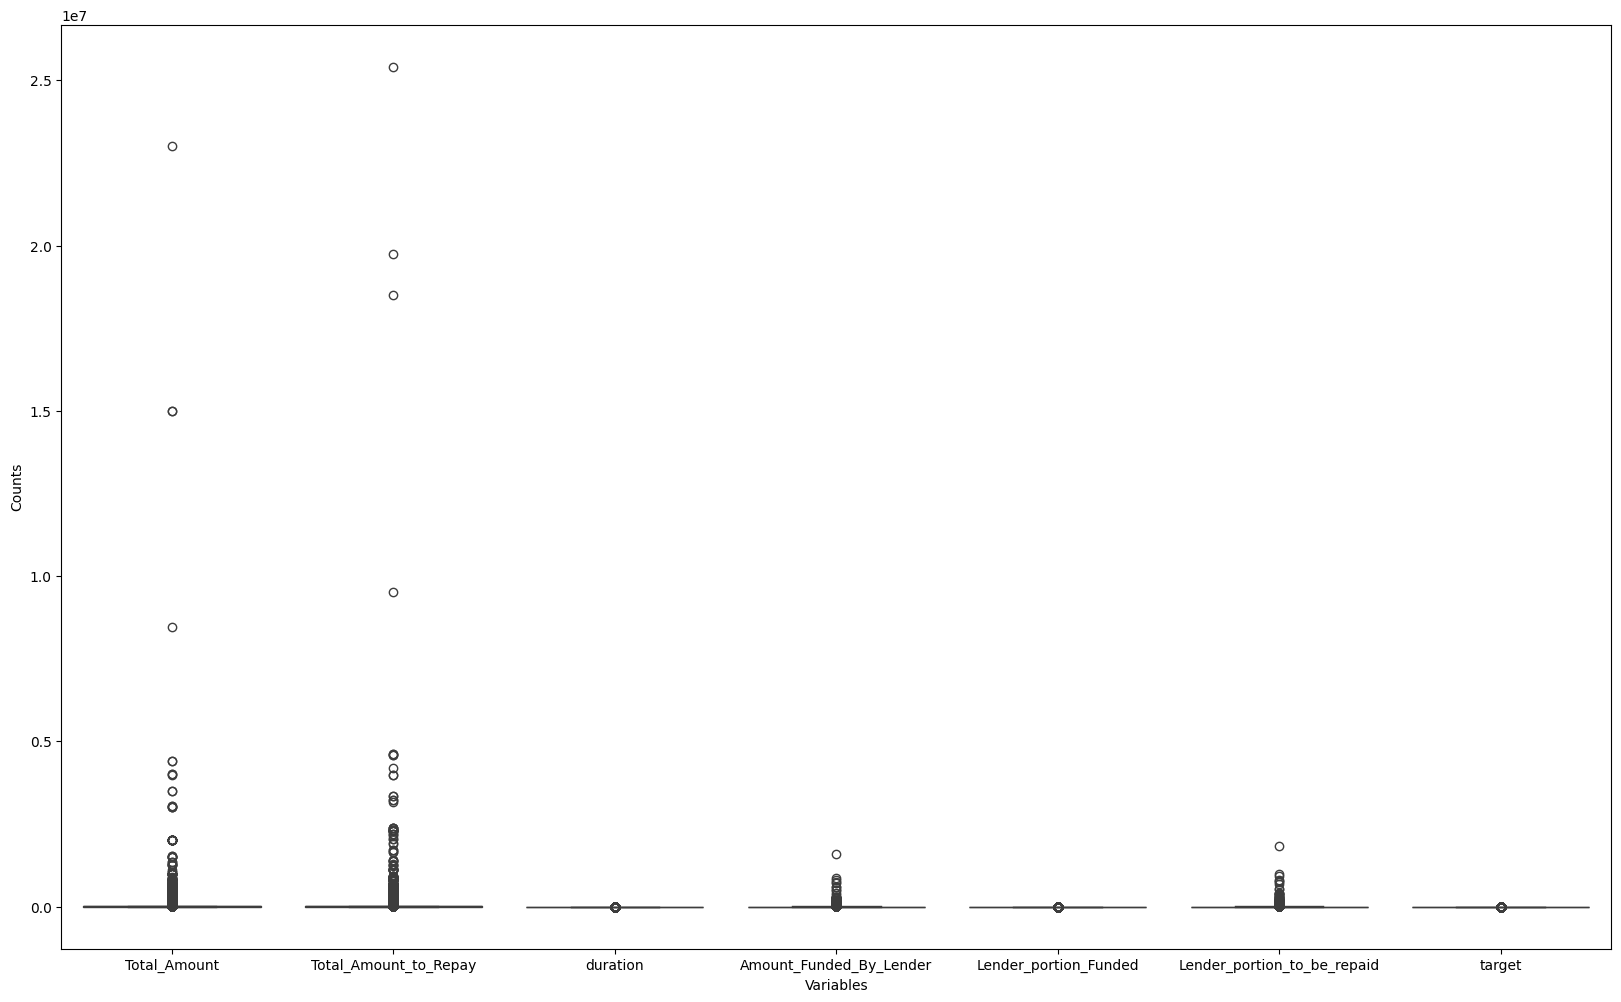

In [ ]:
# @title
plt.figure(figsize=(20, 12))
sns.boxplot(num2)
plt.xlabel('Variables')

plt.ylabel('Counts')

# Display the plot to visualize it.
plt.show()


In [ ]:
cat = df.select_dtypes(exclude=np.number)
cat.head()

,ID,loan_type,disbursement_date,due_date,New_versus_Repeat
0,ID_266671248032267278,Type_1,2022-08-30,2022-09-06,Repeat Loan
1,ID_248919228515267278,Type_1,2022-07-30,2022-08-06,Repeat Loan
2,ID_308486370501251804,Type_7,2024-09-06,2024-09-13,Repeat Loan
3,ID_266004285009267278,Type_1,2022-10-20,2022-10-27,Repeat Loan
4,ID_253803305312267278,Type_1,2022-11-28,2022-12-05,Repeat Loan


In [ ]:
cat = cat.drop(columns=['ID', 'disbursement_date', 'due_date'])
for i in cat.columns:
    print(i)
    print(cat[i].unique())

loan_type
['Type_1' 'Type_7' 'Type_5' 'Type_4' 'Type_6' 'Type_14' 'Type_9' 'Type_10'
 'Type_19' 'Type_16' 'Type_2' 'Type_11' 'Type_23' 'Type_18' 'Type_17'
 'Type_12' 'Type_20' 'Type_13' 'Type_21' 'Type_15' 'Type_24' 'Type_22']
New_versus_Repeat
['Repeat Loan' 'New Loan']


In [ ]:
from sklearn.preprocessing import LabelEncoder

cat2 = cat.copy()
label_encoder_loan_type = LabelEncoder()
# cat['loan_type_encoded'] = label_encoder_loan_type.fit_transform(cat['loan_type'])

label_encoder_repeat = LabelEncoder()
cat2['New_versus_Repeat_encoded'] = label_encoder_repeat.fit_transform(cat2['New_versus_Repeat'])
# cat2['loan_type_encoded'] = label_encoder_loan_type.fit_transform(cat2['loan_type'])
# cat2 = pd.get_dummies(cat2, columns=['loan_type'], drop_first=True)


# # One-Hot Encoding
# cat_one_hot = pd.get_dummies(cat2, columns=['loan_type', ], drop_first=True)
cat2 = pd.get_dummies(cat2, columns=['loan_type'], dtype=int)
# cat2.head(

In [ ]:
cat2.head()

,New_versus_Repeat,New_versus_Repeat_encoded,loan_type_Type_1,loan_type_Type_10,loan_type_Type_11,loan_type_Type_12,loan_type_Type_13,loan_type_Type_14,loan_type_Type_15,loan_type_Type_16,...,loan_type_Type_20,loan_type_Type_21,loan_type_Type_22,loan_type_Type_23,loan_type_Type_24,loan_type_Type_4,loan_type_Type_5,loan_type_Type_6,loan_type_Type_7,loan_type_Type_9
0,Repeat Loan,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Repeat Loan,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Repeat Loan,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,Repeat Loan,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Repeat Loan,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# cat2.loan_type_encoded.sort_values().unique()

In [ ]:
cat2.New_versus_Repeat_encoded.sort_values().unique()

array([0, 1])

In [ ]:
cat3 = cat2.copy()
# cat3.drop(columns=['loan_type', 'New_versus_Repeat'], inplace=True)
cat3.drop(columns=[ 'New_versus_Repeat'], inplace=True)

cat3.head()

,New_versus_Repeat_encoded,loan_type_Type_1,loan_type_Type_10,loan_type_Type_11,loan_type_Type_12,loan_type_Type_13,loan_type_Type_14,loan_type_Type_15,loan_type_Type_16,loan_type_Type_17,...,loan_type_Type_20,loan_type_Type_21,loan_type_Type_22,loan_type_Type_23,loan_type_Type_24,loan_type_Type_4,loan_type_Type_5,loan_type_Type_6,loan_type_Type_7,loan_type_Type_9
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
num2.head()

,Total_Amount,Total_Amount_to_Repay,duration,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
0,8448.0,8448.0,7,120.85,0.014305,121.0,0
1,25895.0,25979.0,7,7768.50,0.300000,7794.0,0
2,6900.0,7142.0,7,1380.00,0.200000,1428.0,0
3,8958.0,9233.0,7,2687.40,0.300000,2770.0,0
4,4564.0,4728.0,7,1369.20,0.300000,1418.0,0


In [ ]:
# @title
# columns_to_transform = cat3.columns
# for col in columns_to_transform:
#     cat3[col] = np.log1p(cat3[col])

In [ ]:
data = pd.concat([cat3, num2], axis=1)
data.head()

,New_versus_Repeat_encoded,loan_type_Type_1,loan_type_Type_10,loan_type_Type_11,loan_type_Type_12,loan_type_Type_13,loan_type_Type_14,loan_type_Type_15,loan_type_Type_16,loan_type_Type_17,...,loan_type_Type_6,loan_type_Type_7,loan_type_Type_9,Total_Amount,Total_Amount_to_Repay,duration,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,8448.0,8448.0,7,120.85,0.014305,121.0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,25895.0,25979.0,7,7768.50,0.300000,7794.0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,1,0,6900.0,7142.0,7,1380.00,0.200000,1428.0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,8958.0,9233.0,7,2687.40,0.300000,2770.0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,4564.0,4728.0,7,1369.20,0.300000,1418.0,0


In [ ]:
data.shape

(68654, 30)

In [ ]:
df.shape

(68654, 12)

In [ ]:
# @title
# # Convert to datetime format
# df['disbursement_date'] = pd.to_datetime(df['disbursement_date'], format='%Y-%m-%d')
# df['due_date'] = pd.to_datetime(df['due_date'], format='%Y-%m-%d')

# # Example: Calculate loan duration in days
# df['loan_duration_days'] = (df['due_date'] - df['disbursement_date']).dt.days

# # Display processed DataFrame
# (df['loan_duration_days'].unique())

In [ ]:
# @title
# data['loan_duration_days'] = df['loan_duration_days']
# data.head()

In [ ]:
data.describe()

,New_versus_Repeat_encoded,loan_type_Type_1,loan_type_Type_10,loan_type_Type_11,loan_type_Type_12,loan_type_Type_13,loan_type_Type_14,loan_type_Type_15,loan_type_Type_16,loan_type_Type_17,...,loan_type_Type_6,loan_type_Type_7,loan_type_Type_9,Total_Amount,Total_Amount_to_Repay,duration,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
count,68654.000000,68654.000000,68654.000000,68654.000000,68654.000000,68654.000000,68654.000000,68654.000000,68654.000000,68654.000000,...,68654.000000,68654.000000,68654.000000,6.865400e+04,6.865400e+04,68654.000000,6.865400e+04,68654.000000,6.865400e+04,68654.000000
mean,0.991741,0.899044,0.006788,0.000612,0.000306,0.000146,0.001442,0.000058,0.000175,0.000335,...,0.005200,0.040639,0.002986,1.483683e+04,1.563993e+04,8.544586,2.545663e+03,0.218679,2.652621e+03,0.018324
std,0.090503,0.301272,0.082108,0.024726,0.017487,0.012068,0.037947,0.007633,0.013220,0.018300,...,0.071924,0.197453,0.054563,1.416499e+05,1.650784e+05,13.343145,1.192272e+04,0.129832,1.338006e+04,0.134120
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.295000e+03,2.329000e+03,7.000000,2.340000e+02,0.118712,2.390000e+02,0.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,5.249000e+03,5.325000e+03,7.000000,9.150000e+02,0.300000,9.340000e+02,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.145000e+04,1.165000e+04,7.000000,2.272650e+03,0.300000,2.317000e+03,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,2.300000e+07,2.541500e+07,1096.000000,1.600000e+06,1.168119,1.821338e+06,1.000000


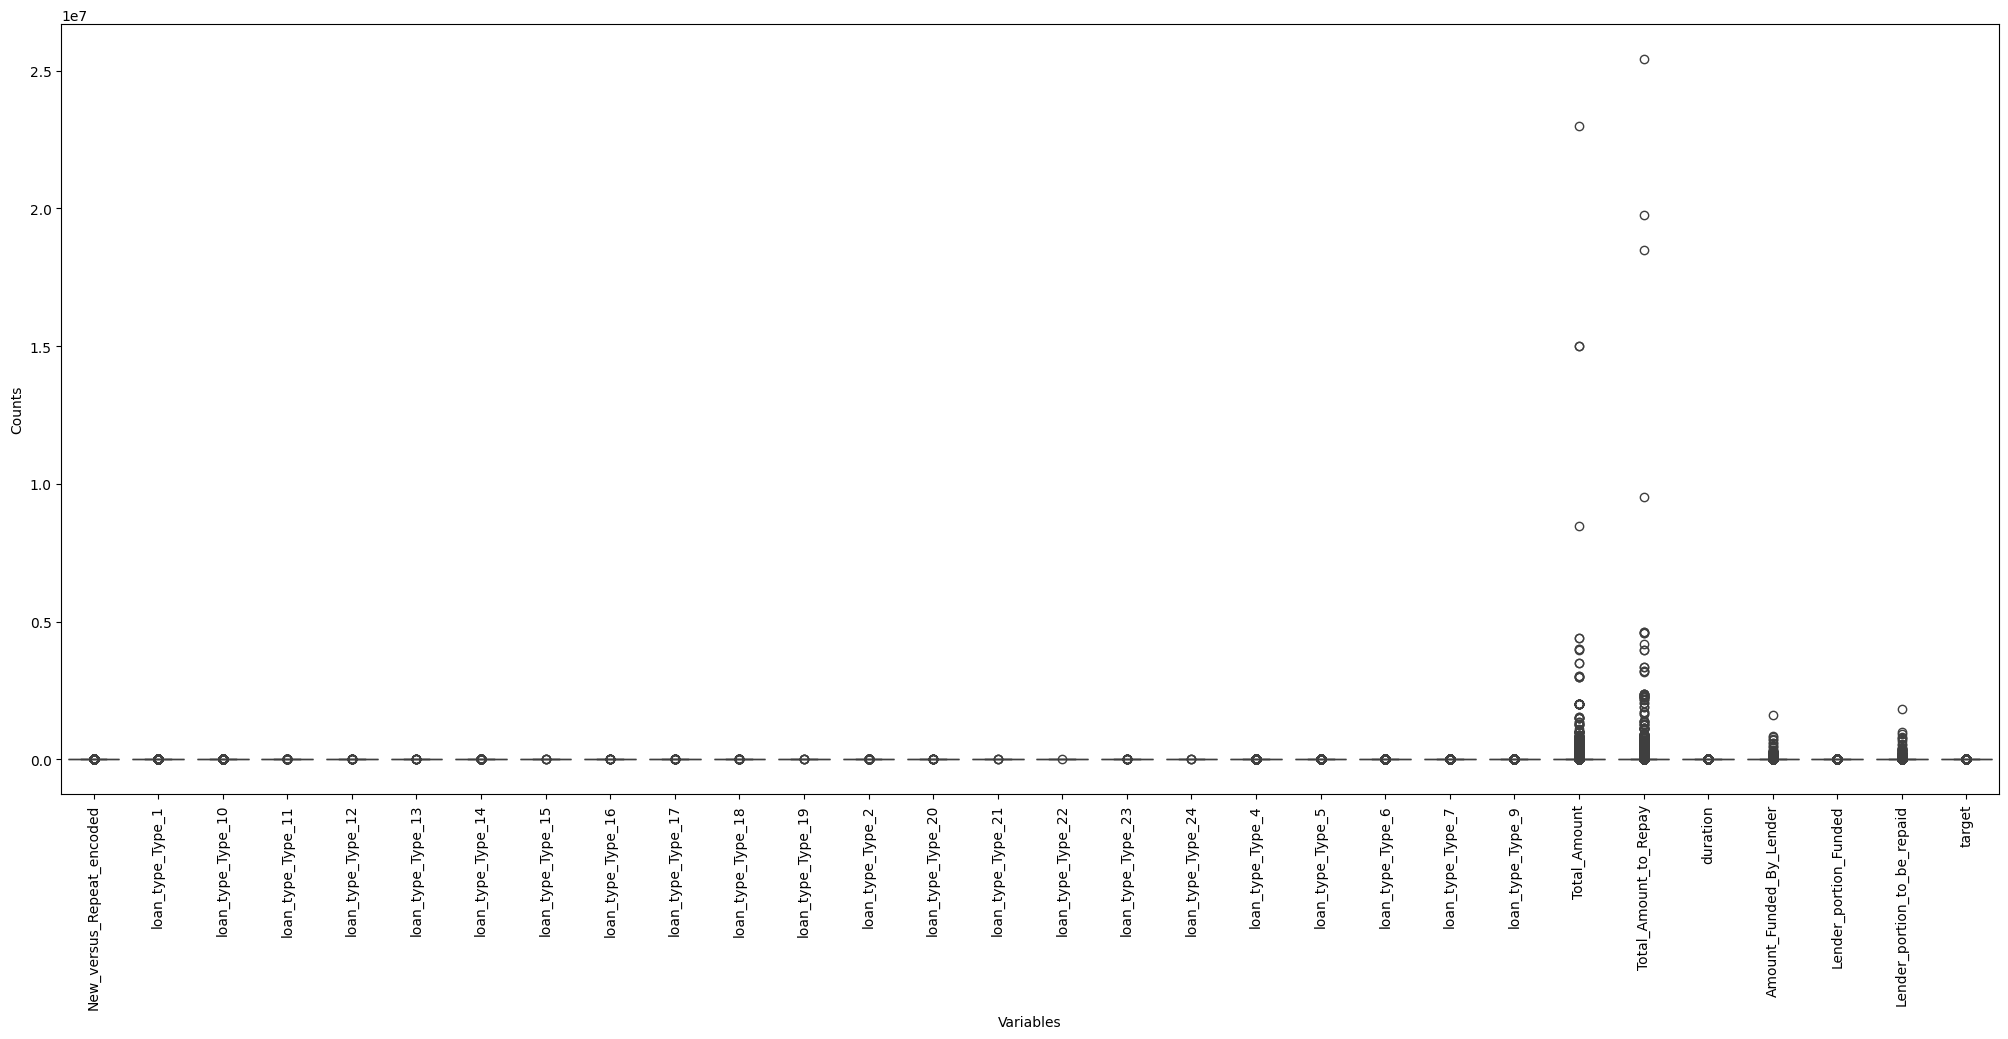

In [ ]:
plt.figure(figsize=(25, 10))
sns.boxplot(data)
plt.xticks(rotation=90)
plt.xlabel('Variables')

plt.ylabel('Counts')

# Display the plot to visualize it.
plt.show()


In [ ]:
# data['loan_duration_days'] = np.log1p(data['loan_duration_days'])

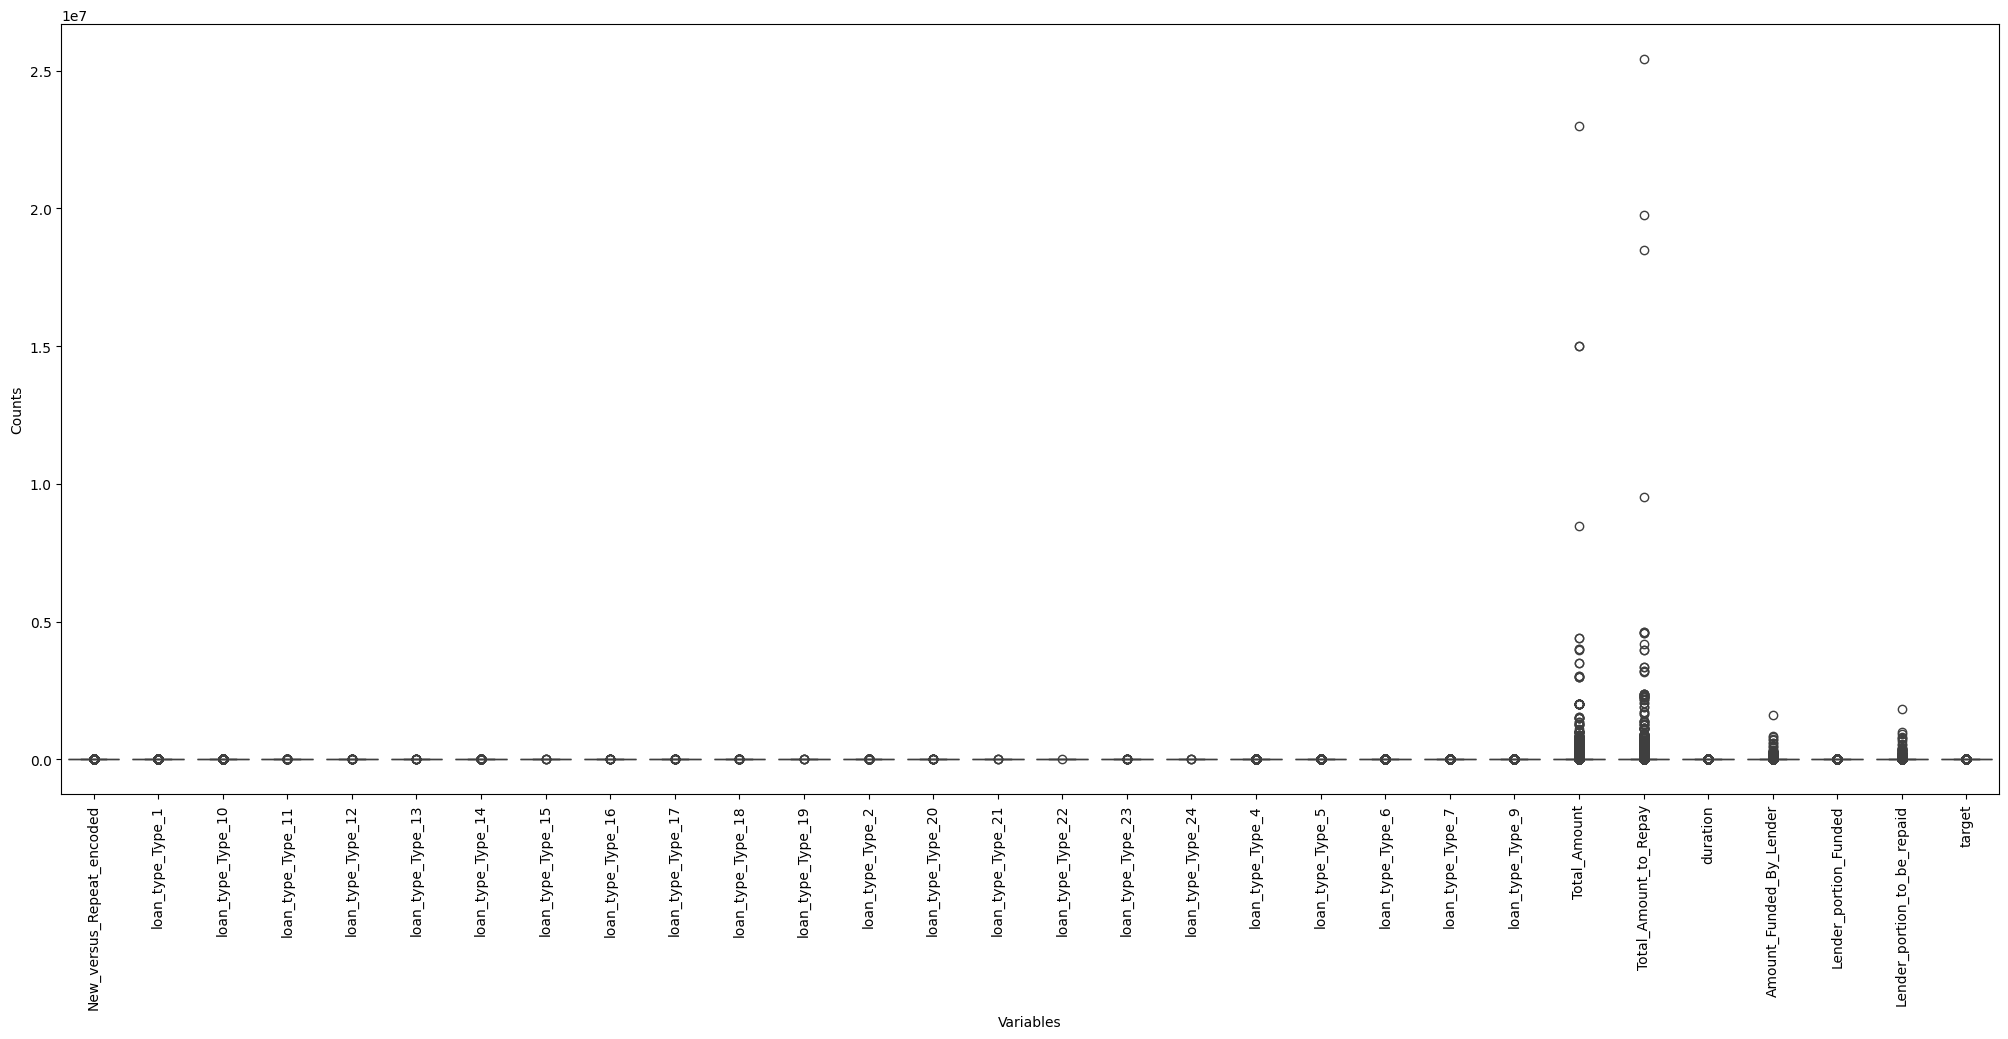

In [ ]:
plt.figure(figsize=(25, 10))
sns.boxplot(data)
plt.xticks(rotation=90)
plt.xlabel('Variables')

plt.ylabel('Counts')

# Display the plot to visualize it.
plt.show()


In [ ]:
data.columns
# data[['loan_type_Type_3', 'loan_type_Type_8']] = 0

Index(['New_versus_Repeat_encoded', 'loan_type_Type_1', 'loan_type_Type_10',
       'loan_type_Type_11', 'loan_type_Type_12', 'loan_type_Type_13',
       'loan_type_Type_14', 'loan_type_Type_15', 'loan_type_Type_16',
       'loan_type_Type_17', 'loan_type_Type_18', 'loan_type_Type_19',
       'loan_type_Type_2', 'loan_type_Type_20', 'loan_type_Type_21',
       'loan_type_Type_22', 'loan_type_Type_23', 'loan_type_Type_24',
       'loan_type_Type_4', 'loan_type_Type_5', 'loan_type_Type_6',
       'loan_type_Type_7', 'loan_type_Type_9', 'Total_Amount',
       'Total_Amount_to_Repay', 'duration', 'Amount_Funded_By_Lender',
       'Lender_portion_Funded', 'Lender_portion_to_be_repaid', 'target'],
      dtype='object')

In [ ]:
len(data.columns)

30

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
# scaler = StandardScaler()
scaler = MinMaxScaler()

# scaled_data = scaler.fit_transform(data[['New_versus_Repeat_encoded', 'loan_type_Type_10', 'loan_type_Type_11',
#        'loan_type_Type_13', 'loan_type_Type_14', 'loan_type_Type_16',
#        'loan_type_Type_17', 'loan_type_Type_18', 'loan_type_Type_2',
#        'loan_type_Type_4', 'loan_type_Type_5', 'loan_type_Type_6',
#        'loan_type_Type_7', 'loan_type_Type_9', 'Total_Amount',
#        'Total_Amount_to_Repay', 'duration', 'Amount_Funded_By_Lender',
#        'Lender_portion_Funded', 'Lender_portion_to_be_repaid']])


scaled_data = scaler.fit_transform(data[['New_versus_Repeat_encoded', 'Total_Amount',
       'Total_Amount_to_Repay', 'duration', 'Amount_Funded_By_Lender',
       'Lender_portion_Funded', 'Lender_portion_to_be_repaid']])


# scaled_data = scaler.fit_transform(data[['New_versus_Repeat_encoded', 'loan_type_encoded', 'Total_Amount',
#        'Total_Amount_to_Repay', 'duration', 'Amount_Funded_By_Lender',
#        'Lender_portion_Funded', 'Lender_portion_to_be_repaid']])

# Convert to DataFrame and specify the correct column names
# scaled_data_df = pd.DataFrame(scaled_data, columns=['New_versus_Repeat_encoded', 'loan_type_encoded', 'Total_Amount',
#        'Total_Amount_to_Repay', 'duration', 'Amount_Funded_By_Lender',
#        'Lender_portion_Funded', 'Lender_portion_to_be_repaid'])


scaled_data_df = pd.DataFrame(scaled_data, columns=['New_versus_Repeat_encoded', 'Total_Amount',
       'Total_Amount_to_Repay', 'duration', 'Amount_Funded_By_Lender',
       'Lender_portion_Funded', 'Lender_portion_to_be_repaid'])



# scaled_data_df = pd.DataFrame(scaled_data, columns=['New_versus_Repeat_encoded', 'loan_type_Type_10', 'loan_type_Type_11',
#        'loan_type_Type_13', 'loan_type_Type_14', 'loan_type_Type_16',
#        'loan_type_Type_17', 'loan_type_Type_18', 'loan_type_Type_2',
#        'loan_type_Type_4', 'loan_type_Type_5', 'loan_type_Type_6',
#        'loan_type_Type_7', 'loan_type_Type_9', 'Total_Amount',
#        'Total_Amount_to_Repay', 'duration', 'Amount_Funded_By_Lender',
#        'Lender_portion_Funded', 'Lender_portion_to_be_repaid'])



scaled_data_df['target'] = df['target']
# Display the first few rows
scaled_data_df.head()

,New_versus_Repeat_encoded,Total_Amount,Total_Amount_to_Repay,duration,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
0,1.0,0.000367,0.000332,0.005479,0.000076,0.012246,0.000066,0
1,1.0,0.001126,0.001022,0.005479,0.004855,0.256823,0.004279,0
2,1.0,0.000300,0.000281,0.005479,0.000863,0.171215,0.000784,0
3,1.0,0.000389,0.000363,0.005479,0.001680,0.256823,0.001521,0
4,1.0,0.000198,0.000186,0.005479,0.000856,0.256823,0.000779,0


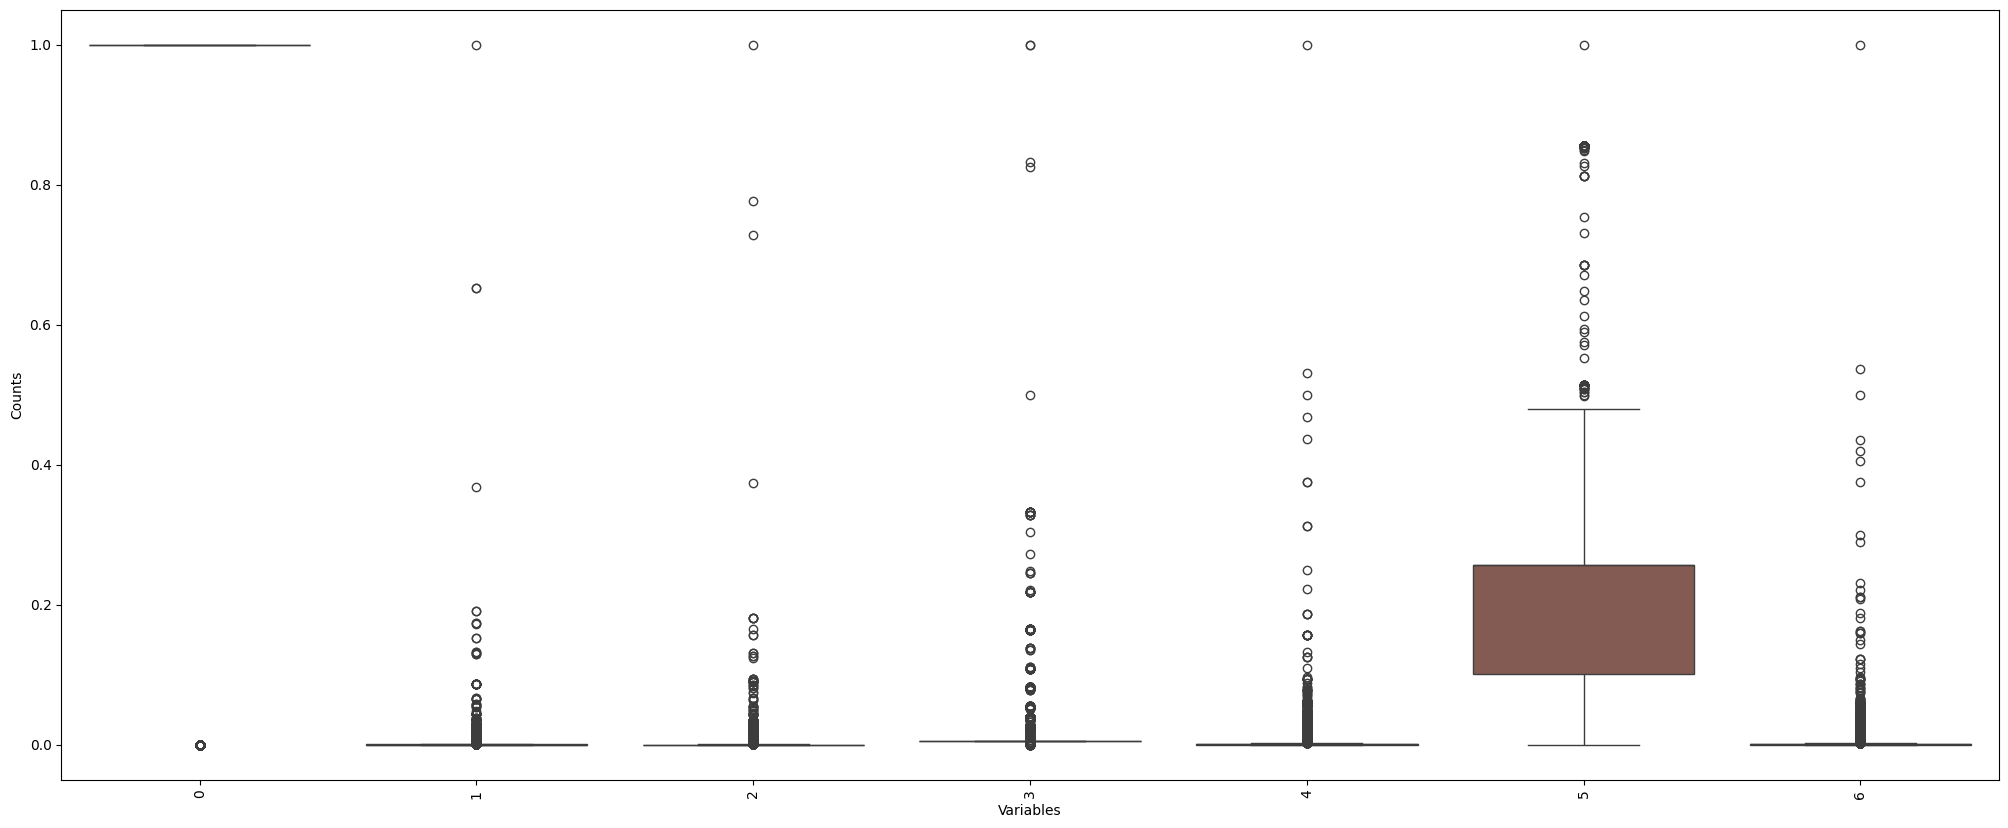

In [ ]:
# @title
plt.figure(figsize=(25, 10))
sns.boxplot(scaled_data)
plt.xticks(rotation=90)
plt.xlabel('Variables')

plt.ylabel('Counts')

# Display the plot to visualize it.
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
X = data.drop(columns=['target'], axis=1)
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
data['target'].head()

,target
0,0
1,0
2,0
3,0
4,0


In [ ]:
# Calculate the class imbalance ratio
negative_class_count = (y_train == 0).sum()  # Count of negative class (0)
positive_class_count = (y_train == 1).sum()  # Count of positive class (1)

ratio = negative_class_count / positive_class_count  # Ratio of negative to positive



from xgboost import XGBClassifier
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
model.score(X_test, y_test)

0.991479134804457

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     13487
           1       0.85      0.64      0.73       244

    accuracy                           0.99     13731
   macro avg       0.92      0.82      0.86     13731
weighted avg       0.99      0.99      0.99     13731



0.7259953161592507

In [ ]:
confusion_matrix(y_test, y_pred)

array([[13459,    28],
       [   89,   155]])

In [ ]:
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier()
cat_model.fit(X_train, y_train)

y_pred = cat_model.predict(X_test)
cat_model.score(X_test, y_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(f1_score(y_test, y_pred))

Learning rate set to 0.056991
0:	learn: 0.5725867	total: 22.4ms	remaining: 22.4s
1:	learn: 0.4774151	total: 37ms	remaining: 18.5s
2:	learn: 0.4050517	total: 50.8ms	remaining: 16.9s
3:	learn: 0.3461805	total: 65ms	remaining: 16.2s
4:	learn: 0.2997235	total: 81.9ms	remaining: 16.3s
5:	learn: 0.2615476	total: 101ms	remaining: 16.7s
6:	learn: 0.2273756	total: 124ms	remaining: 17.6s
7:	learn: 0.2033221	total: 141ms	remaining: 17.5s
8:	learn: 0.1822004	total: 162ms	remaining: 17.8s
9:	learn: 0.1654186	total: 180ms	remaining: 17.8s
10:	learn: 0.1510157	total: 198ms	remaining: 17.8s
11:	learn: 0.1398925	total: 223ms	remaining: 18.4s
12:	learn: 0.1297906	total: 239ms	remaining: 18.1s
13:	learn: 0.1221023	total: 252ms	remaining: 17.8s
14:	learn: 0.1157006	total: 266ms	remaining: 17.5s
15:	learn: 0.1095553	total: 280ms	remaining: 17.2s
16:	learn: 0.1032394	total: 294ms	remaining: 17s
17:	learn: 0.0982749	total: 309ms	remaining: 16.9s
18:	learn: 0.0949262	total: 323ms	remaining: 16.7s
19:	learn: 0

In [ ]:
# @title
# from sklearn.linear_model import LogisticRegression
# model = LogisticRegression(class_weight='balanced')
# model.fit(X_train, y_train)

# y_pred2 = model.predict(X_test)
# model.score(X_test, y_test)
# print(confusion_matrix(y_test, y_pred2))
# print(f1_score(y_test, y_pred2))

In [ ]:
# @title
# from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier()
# model.fit(X_train, y_train)

# y_pred3 = model.predict(X_test)
# model.score(X_test, y_test)
# print(confusion_matrix(y_test, y_pred3))
# print(f1_score(y_test, y_pred3))

In [ ]:
# @title
# !pip install catboost
# from catboost import CatBoostClassifier
# model = CatBoostClassifier()
# model.fit(X_train, y_train)

# y_pred4 = model.predict(X_test)


In [ ]:
# @title
# model.score(X_test, y_test)
# print(confusion_matrix(y_test, y_pred4))
# print(f1_score(y_test, y_pred4))

In [ ]:
# Train LightGBM
lgb_model = LGBMClassifier(random_state=42, learning_rate=0.2, max_depth=10, n_estimators=200, num_leaves=50)
lgb_model.fit(X_train, y_train)

# Predictions
y_pred = lgb_model.predict(X_test)
print("LightGBM Accuracy:", accuracy_score(y_test, y_pred))
print("LightGBM Classification Report:")
print(classification_report(y_test, y_pred))
print("LightGBM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("LightGBM F1 Score:", f1_score(y_test, y_pred))


[LightGBM] [Info] Number of positive: 1014, number of negative: 53909
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1348
[LightGBM] [Info] Number of data points in the train set: 54923, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018462 -> initscore=-3.973395
[LightGBM] [Info] Start training from score -3.973395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [ ]:
# Train GBM
gbm_model = GradientBoostingClassifier(random_state=42, learning_rate=0.1, max_depth=10, n_estimators=200)
gbm_model.fit(X_train, y_train)

# Predictions
y_pred = gbm_model.predict(X_test)
print("GBM Accuracy:", accuracy_score(y_test, y_pred))
print("GBM Classification Report:")
print(classification_report(y_test, y_pred))
print("GBM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("GBM F1 Score:", f1_score(y_test, y_pred))


GBM Accuracy: 0.9923530696963077
GBM Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     13487
           1       0.86      0.68      0.76       244

    accuracy                           0.99     13731
   macro avg       0.93      0.84      0.88     13731
weighted avg       0.99      0.99      0.99     13731

GBM Confusion Matrix:
[[13459    28]
 [   77   167]]
GBM F1 Score: 0.7608200455580866


In [ ]:
# Train Ensemble (Stacking)
estimators = [
    ('lgb', lgb_model),
    ('gbm', gbm_model)
    # ,
    # ('svm', svm_model)
]
stack_model_1 = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier(random_state=42))
stack_model_1.fit(X_train, y_train)

# Predictions
y_pred = stack_model_1.predict(X_test)
print("Stacking Ensemble Accuracy:", accuracy_score(y_test, y_pred))
print("Stacking Ensemble Classification Report:")
print(classification_report(y_test, y_pred))
print("Stacking Ensemble Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


[LightGBM] [Info] Number of positive: 1014, number of negative: 53909
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1348
[LightGBM] [Info] Number of data points in the train set: 54923, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018462 -> initscore=-3.973395
[LightGBM] [Info] Start training from score -3.973395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [ ]:
print("Stacking Ensemble F1 Score:", f1_score(y_test, y_pred))

Stacking Ensemble F1 Score: 0.7873303167420814


In [ ]:
# Train Ensemble (Stacking)
estimators = [
    ('lgb', lgb_model),
    ('sbm', stack_model_1)
    # ,
    # ('svm', svm_model)
]
stack_model_2 = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier(random_state=42))
stack_model_2.fit(X_train, y_train)

# Predictions
y_pred = stack_model_2.predict(X_test)
print("Stacking Ensemble Accuracy:", accuracy_score(y_test, y_pred))
print("Stacking Ensemble Classification Report:")
print(classification_report(y_test, y_pred))
print("Stacking Ensemble Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


[LightGBM] [Info] Number of positive: 1014, number of negative: 53909
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1348
[LightGBM] [Info] Number of data points in the train set: 54923, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018462 -> initscore=-3.973395
[LightGBM] [Info] Start training from score -3.973395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [ ]:
print("Stacking Ensemble F1 Score:", f1_score(y_test, y_pred))

Stacking Ensemble F1 Score: 0.808695652173913


In [ ]:
# smote = SMOTE(random_state=42)  # You can adjust the random_state for reproducibility

# # Apply SMOTE to the training data
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)



In [ ]:
# model = XGBClassifier()
# model.fit(X_train_resampled, y_train_resampled)

# y_pred5 = model.predict(X_test)
# model.score(X_test, y_test)
# print(confusion_matrix(y_test, y_pred5))
# print(f1_score(y_test, y_pred5))

In [ ]:
# model = CatBoostClassifier()
# model.fit(X_train_resampled, y_train_resampled)

# y_pred6 = model.predict(X_test)


In [ ]:
# model.score(X_test, y_test)
# print(confusion_matrix(y_test, y_pred6))
# print(f1_score(y_test, y_pred6))

In [ ]:
test = pd.read_csv('Test.csv')
test.head()

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid
0,ID_269404226088267278,269404,Kenya,226088,267278,Type_1,1919.0,1989.0,2022-07-27,2022-08-03,7,Repeat Loan,575.7,0.300000,597.0
1,ID_255356300042267278,255356,Kenya,300042,267278,Type_1,2138.0,2153.0,2022-11-16,2022-11-23,7,Repeat Loan,0.0,0.000000,0.0
2,ID_257026243764267278,257026,Kenya,243764,267278,Type_1,8254.0,8304.0,2022-08-24,2022-08-31,7,Repeat Loan,207.0,0.025079,208.0
3,ID_264617299409267278,264617,Kenya,299409,267278,Type_1,3379.0,3379.0,2022-11-15,2022-11-22,7,Repeat Loan,1013.7,0.300000,1014.0
4,ID_247613296713267278,247613,Kenya,296713,267278,Type_1,120.0,120.0,2022-11-10,2022-11-17,7,Repeat Loan,36.0,0.300000,36.0


In [ ]:
cols_to_drop = ['customer_id',	'country_id',	'tbl_loan_id',	'lender_id']
test.drop(cols_to_drop, axis=1, inplace=True)
test.head()

,ID,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid
0,ID_269404226088267278,Type_1,1919.0,1989.0,2022-07-27,2022-08-03,7,Repeat Loan,575.7,0.300000,597.0
1,ID_255356300042267278,Type_1,2138.0,2153.0,2022-11-16,2022-11-23,7,Repeat Loan,0.0,0.000000,0.0
2,ID_257026243764267278,Type_1,8254.0,8304.0,2022-08-24,2022-08-31,7,Repeat Loan,207.0,0.025079,208.0
3,ID_264617299409267278,Type_1,3379.0,3379.0,2022-11-15,2022-11-22,7,Repeat Loan,1013.7,0.300000,1014.0
4,ID_247613296713267278,Type_1,120.0,120.0,2022-11-10,2022-11-17,7,Repeat Loan,36.0,0.300000,36.0


In [ ]:
num = test.select_dtypes(include=np.number)


In [ ]:
num2 = num.copy()
# columns_to_transform = num2.columns
# for col in columns_to_transform:
#     num2[col] = np.log1p(num2[col])

In [ ]:
cat = test.select_dtypes(exclude=np.number)
cat.head()

,ID,loan_type,disbursement_date,due_date,New_versus_Repeat
0,ID_269404226088267278,Type_1,2022-07-27,2022-08-03,Repeat Loan
1,ID_255356300042267278,Type_1,2022-11-16,2022-11-23,Repeat Loan
2,ID_257026243764267278,Type_1,2022-08-24,2022-08-31,Repeat Loan
3,ID_264617299409267278,Type_1,2022-11-15,2022-11-22,Repeat Loan
4,ID_247613296713267278,Type_1,2022-11-10,2022-11-17,Repeat Loan


In [ ]:
cat = cat.drop(columns=['ID', 'disbursement_date', 'due_date'])
for i in cat.columns:
    print(i)
    print(cat[i].unique())

loan_type
['Type_1' 'Type_7' 'Type_3' 'Type_2' 'Type_10' 'Type_6' 'Type_23'
 'Type_14' 'Type_5' 'Type_4' 'Type_17' 'Type_9' 'Type_12' 'Type_8'
 'Type_11' 'Type_18' 'Type_24' 'Type_22' 'Type_20' 'Type_15' 'Type_21'
 'Type_13']
New_versus_Repeat
['Repeat Loan' 'New Loan']


In [ ]:
from sklearn.preprocessing import LabelEncoder

cat2 = cat.copy()
label_encoder_loan_type = LabelEncoder()
# cat['loan_type_encoded'] = label_encoder_loan_type.fit_transform(cat['loan_type'])

label_encoder_repeat = LabelEncoder()
cat2['New_versus_Repeat_encoded'] = label_encoder_repeat.fit_transform(cat2['New_versus_Repeat'])
# cat2['loan_type_encoded'] = label_encoder_loan_type.fit_transform(cat2['loan_type'])
# cat2 = pd.get_dummies(cat2, columns=['loan_type'], drop_first=True)


# # One-Hot Encoding
# cat_one_hot = pd.get_dummies(cat2, columns=['loan_type', ], drop_first=True)
cat2 = pd.get_dummies(cat2, columns=['loan_type'], dtype=int)
# cat2.head(

In [ ]:
cat3 = cat2.copy()
# cat3.drop(columns=['loan_type', 'New_versus_Repeat'], inplace=True)
cat3.drop(columns=[ 'New_versus_Repeat'], inplace=True)

cat3.head()

,New_versus_Repeat_encoded,loan_type_Type_1,loan_type_Type_10,loan_type_Type_11,loan_type_Type_12,loan_type_Type_13,loan_type_Type_14,loan_type_Type_15,loan_type_Type_17,loan_type_Type_18,...,loan_type_Type_22,loan_type_Type_23,loan_type_Type_24,loan_type_Type_3,loan_type_Type_4,loan_type_Type_5,loan_type_Type_6,loan_type_Type_7,loan_type_Type_8,loan_type_Type_9
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
data = pd.concat([cat3, num2], axis=1)
data[['loan_type_Type_16', 'loan_type_Type_19']] = 0
data.head()
data.head()

,New_versus_Repeat_encoded,loan_type_Type_1,loan_type_Type_10,loan_type_Type_11,loan_type_Type_12,loan_type_Type_13,loan_type_Type_14,loan_type_Type_15,loan_type_Type_17,loan_type_Type_18,...,loan_type_Type_8,loan_type_Type_9,Total_Amount,Total_Amount_to_Repay,duration,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,loan_type_Type_16,loan_type_Type_19
0,1,1,0,0,0,0,0,0,0,0,...,0,0,1919.0,1989.0,7,575.7,0.300000,597.0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,2138.0,2153.0,7,0.0,0.000000,0.0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,8254.0,8304.0,7,207.0,0.025079,208.0,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,3379.0,3379.0,7,1013.7,0.300000,1014.0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,120.0,120.0,7,36.0,0.300000,36.0,0,0


In [ ]:
scaled_data = scaler.fit_transform(data[['New_versus_Repeat_encoded', 'Total_Amount',
       'Total_Amount_to_Repay', 'duration', 'Amount_Funded_By_Lender',
       'Lender_portion_Funded', 'Lender_portion_to_be_repaid']])


# scaled_data = scaler.fit_transform(data[['New_versus_Repeat_encoded', 'loan_type_encoded', 'Total_Amount',
#        'Total_Amount_to_Repay', 'duration', 'Amount_Funded_By_Lender',
#        'Lender_portion_Funded', 'Lender_portion_to_be_repaid']])

# Convert to DataFrame and specify the correct column names
# scaled_data_df = pd.DataFrame(scaled_data, columns=['New_versus_Repeat_encoded', 'loan_type_encoded', 'Total_Amount',
#        'Total_Amount_to_Repay', 'duration', 'Amount_Funded_By_Lender',
#        'Lender_portion_Funded', 'Lender_portion_to_be_repaid'])


scaled_data_df = pd.DataFrame(scaled_data, columns=['New_versus_Repeat_encoded', 'Total_Amount',
       'Total_Amount_to_Repay', 'duration', 'Amount_Funded_By_Lender',
       'Lender_portion_Funded', 'Lender_portion_to_be_repaid'])


In [ ]:
model_features = model.get_booster().feature_names
data = data[model_features]  # Ensure the order matches
data['target'] = stack_model.predict(data)


NameError: name 'stack_model' is not defined

In [ ]:
# data['target'] = model.predict(data)

In [ ]:
# Feature names from the trained model
model_features = model.get_booster().feature_names

# Feature names in the dataset
data_features = data.columns.tolist()

# Identify missing features
missing_features = set(model_features) - set(data_features)
extra_features = set(data_features) - set(model_features)

print("Missing features:", missing_features)
print("Extra features:", extra_features)


In [ ]:
data['ID'] = test['ID']
data.head()

In [ ]:
submission = pd.DataFrame({"ID": data["ID"],
                           "target": data.target})

In [ ]:
submission.to_csv(r'C:\Users\Owner\Downloads\playground-series-s4e12\Account_owners2.csv', index=False)
submission.head()


In [ ]:
# Save the predictions to a new CSV file
output_filename = '01test_predictions_new.csv'
data[['ID', 'target']].to_csv(output_filename, index=False)

In [ ]:
# from google.colab import files  # Import for downloading
# files.download(output_filename)

In [ ]:
fin = pd.read_csv('economic_indicators.csv')
fin.head(20)